In [180]:
# In Class Lab 7 Template

# G. Besla
# with code from R. Hoffman, R. Li and E. Patel

# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfileLab import MassProfile

# for contours
import scipy.optimize as so


# Lab 7  Contour Plots and Spiral Arms

In this lab you will: 

A) Use contour plots to identify substructure within the stellar disk of M31.

B) Rotate the disk so that we are seeing it edge on

C) Create plots to examine the kinematics of the disk

D) Create plots to study spiral arms

In [182]:
# Code for plotting contours
# from https://gist.github.com/adrn/3993992


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68)) # 68%
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95)) # 95%
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99)) # 99%
    
    # You might need to add a few levels
    onetwo_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, onetwo_sigma, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.95','0.95','0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

Use the CenterOfMass code to compute the positions and velocities of all particles in M31's disk relative to its center of mass position and motion.

In [184]:
# Create a COM of object for M31 Disk (particle type=2) Using Code from Homework 4
COMD = CenterOfMass("M31_000.txt",2)

In [185]:
# Compute COM of M31 using disk particles
COMP = COMD.COM_P(0.1)
COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

In [186]:
# Determine positions of disk particles relative to COM 
xD = COMD.x - COMP[0].value 
yD = COMD.y - COMP[1].value 
zD = COMD.z - COMP[2].value 

# total magnitude
rtot = np.sqrt(xD**2 + yD**2 + zD**2)

# Determine velocities of disk particles relatiev to COM motion
vxD = COMD.vx - COMV[0].value 
vyD = COMD.vy - COMV[1].value 
vzD = COMD.vz - COMV[2].value 

# total velocity 
vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

# Arrays for r and v 
r = np.array([xD,yD,zD]).T # transposed 
v = np.array([vxD,vyD,vzD]).T

# Part A:

Create plot of M31's disk density, using 2D Histograms 

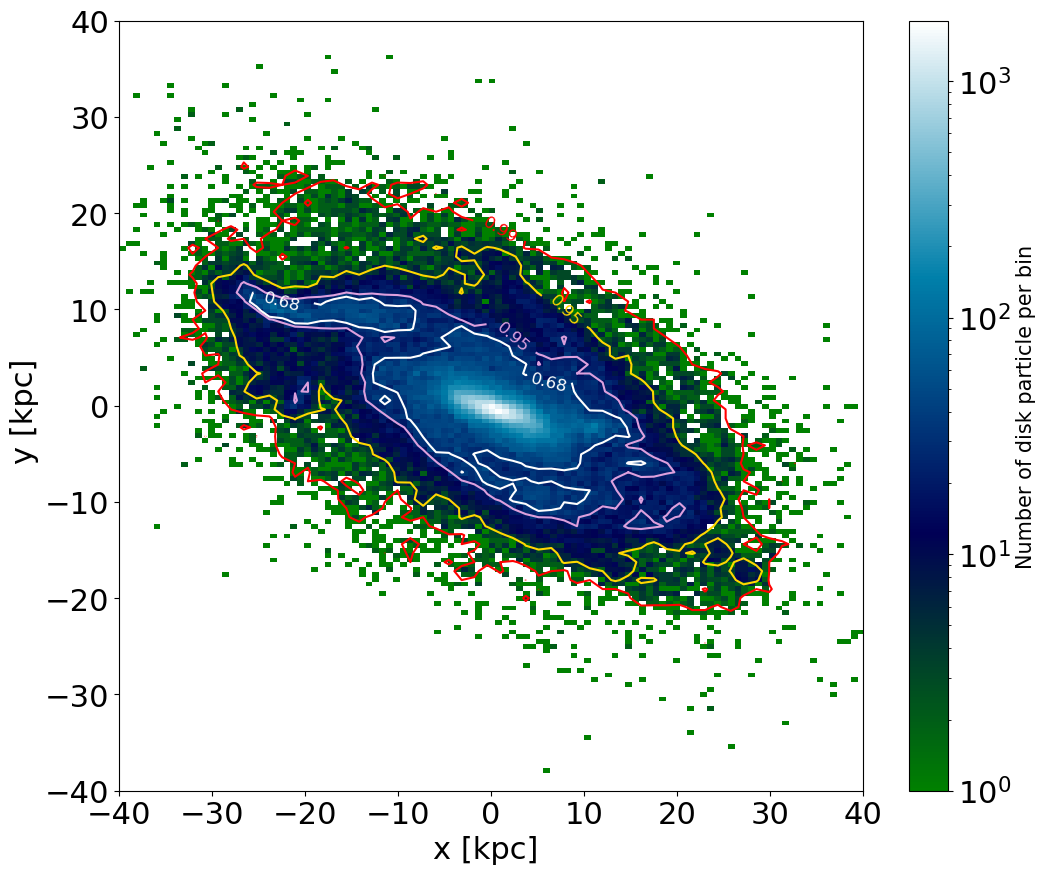

In [188]:
# 1) Make plots 

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(12, 10))


# plot the particle density for M31 using a 2D historgram
# can modify bin number to make the plot smoother

plt.hist2d(xD,yD, bins=150, norm=LogNorm(), cmap='ocean')

cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# remember to adjust this if there are other contours added
# density_contour(pos1, pos2, res1, res2, ax=ax, colors=[])
density_contour(xD, yD, 80, 80, ax=ax, colors=['red', 'gold', 'plum', 'white'])


# Add axis labels
plt.xlabel('x [kpc] ', fontsize=22)
plt.ylabel('y [kpc] ', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save to a file
plt.savefig('Lab7_M31Disk.png')

# Part B

Utilize the below code to rotate the M31 disk and plot it edge on and face on.

What is the sense of rotation of M31 ? 

In [190]:

def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to
    # z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [191]:
# ADD HERE
# compute the rotated position and velocity vectors
rn, vn = RotateFrame(r,v)

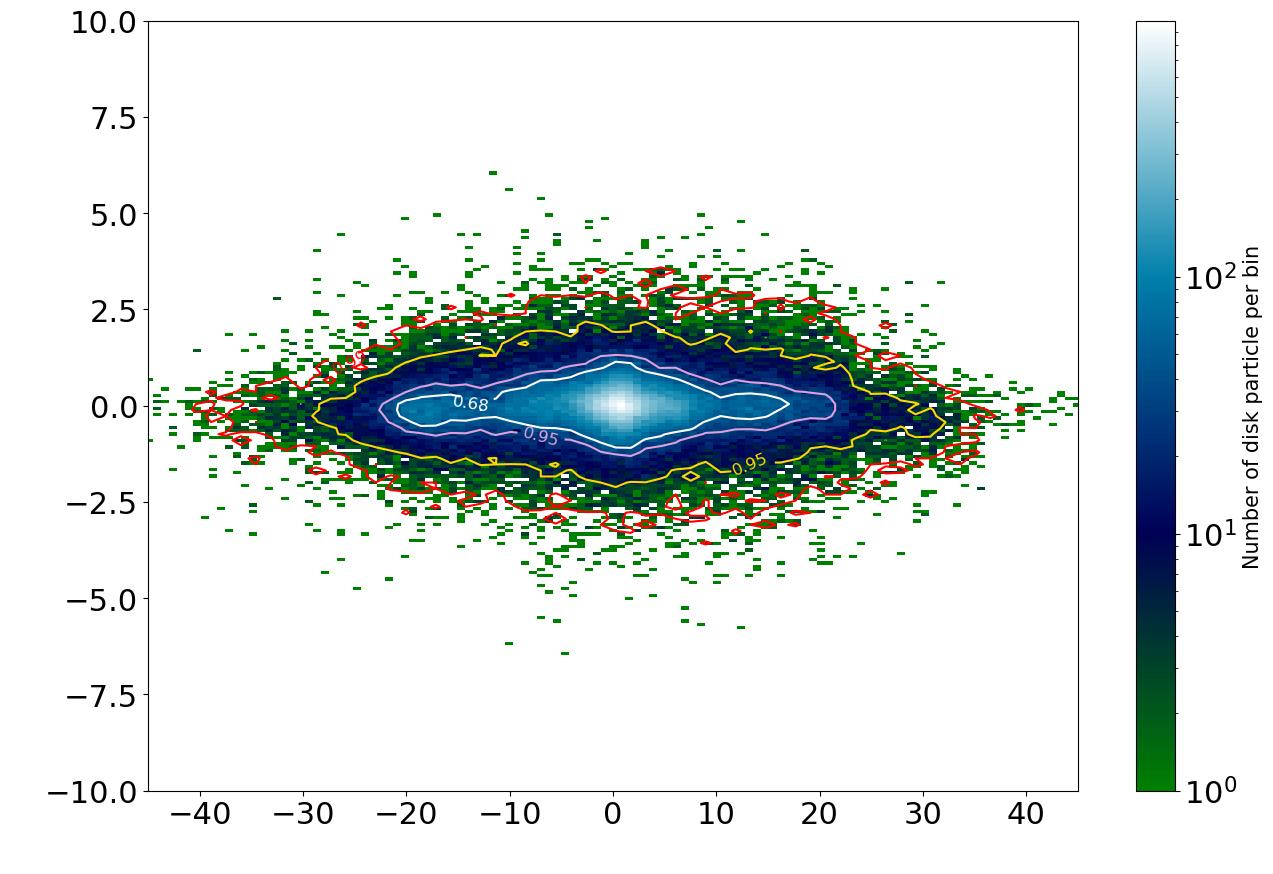

In [192]:
# Rotated M31 Disk - EDGE ON

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(15, 10))

# plot the particle density for M31 , 2D histogram
# ADD HERE
plt.hist2d(rn[:,0], rn[:,2], bins=150, norm=LogNorm(), cmap='ocean')

density_contour(rn[:,0], rn[:,2], 80, 80, ax=ax, colors=['red', 'gold', 'plum', 'white'])

cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)


# Add axis labels
plt.xlabel(' ', fontsize=22)
plt.ylabel(' ', fontsize=22)

#set axis limits
plt.ylim(-10,10)
plt.xlim(-45,45)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Save to a file
plt.savefig('Lab7_EdgeOn_Density.png')


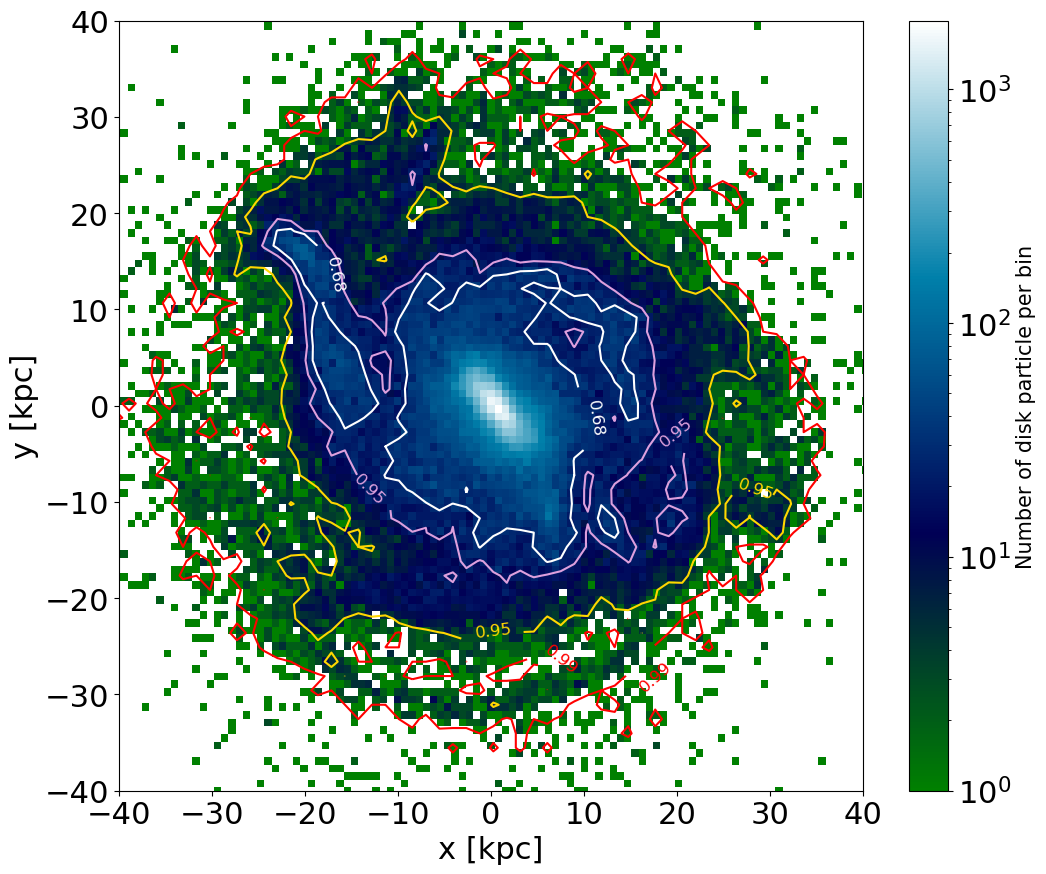

In [193]:
# Rotated M31 Disk - FACE ON

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(12, 10))

# plot the particle density for M31 
# ADD HERE
plt.hist2d(rn[:,0], rn[:,1], bins=150, norm=LogNorm(), cmap='ocean')

cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# ADD HERE
density_contour(rn[:,0], rn[:,1], 80, 80, ax=ax, colors=['red', 'gold', 'plum', 'white'])

# Add axis labels
plt.xlabel('x [kpc]', fontsize=22)
plt.ylabel('y [kpc]', fontsize=22)

#set axis limits
plt.ylim(-40,40)
plt.xlim(-40,40)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Save to a file 
plt.savefig('Lab7_FaceOn_Density.png')


# Part C

a) Create a scatter plot of the edge on disk particles, weighted by velocity.

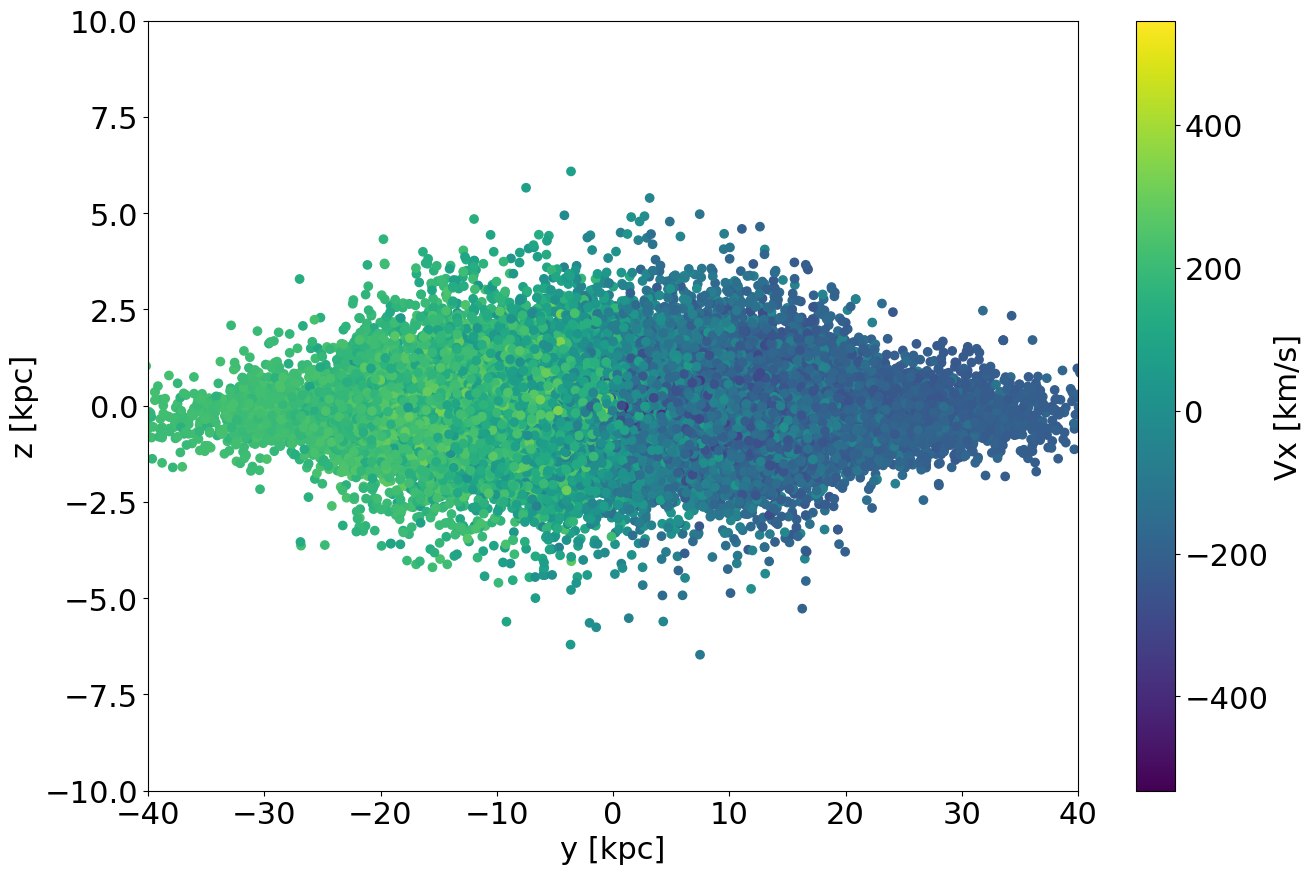

In [195]:
# Plot velocity weighted EDGE ON DISK

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

# plot position of disk particles color 
# coded by velocity along the 3rd axis
# plt.scatter(pos1, pos2, c=vel1)
# ADD HERE 
plt.scatter(rn[:,1], rn[:,2], c=vn[:,0])

#colorbar
cbar = plt.colorbar()
cbar.set_label('Vx [km/s]', size=22)

# Add axis labels
plt.xlabel('y [kpc]', fontsize=22)
plt.ylabel('z [kpc]', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#set axis limits
plt.ylim(-10,10)
plt.xlim(-40,40)

# Save file
plt.savefig('Lab7_EdgeOn_Vel.png')


b) Create a phase diagram for the edge on disk (Position vs. Velocity) using a 2D Histogram.

c) Use the MassProfile Code to overplot the expected circular velocity from the mass profile. 

In [197]:
#Create a mass profile object using homework solutions
M31 = MassProfile('M31', 0)

In [198]:
#Array of positions
rr = np.arange(0.01, 45, 0.1)

In [200]:
#Circular velocity profile
Vcirc = M31.circularVelocityTotal(rr)

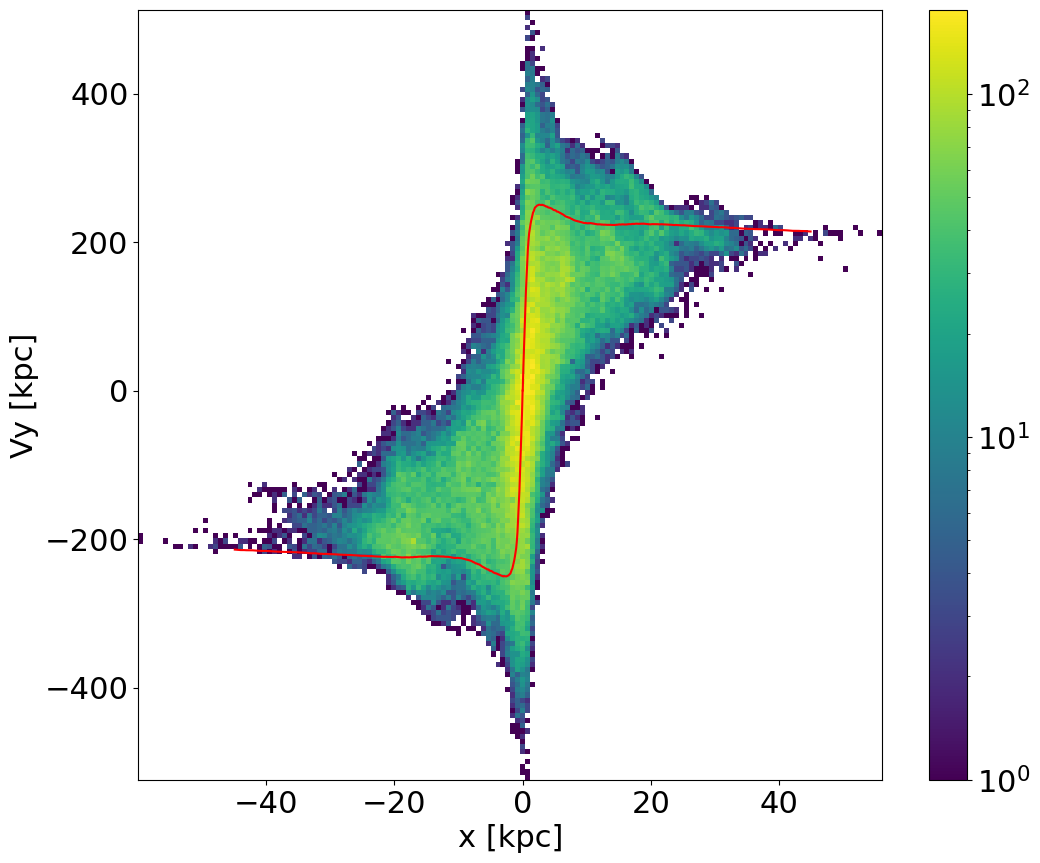

In [202]:
# Make a phase diagram of the R vs V
# MW Disk Velocity Field edge on.

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

# Plot 2D Histogram for one component of  Pos vs Vel 
# ADD HERE
plt.hist2d(rn[:,0], vn[:,1], bins=150, norm=LogNorm())
plt.colorbar()

# Overplot Circular Velocity from the MassProfile Code
# ADD HERE
plt.plot(rr, Vcirc, color='red')
plt.plot(-rr, -Vcirc, color='red')

# Add axis labels
plt.xlabel('x [kpc]', fontsize=22)
plt.ylabel('Vy [kpc]', fontsize=22)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save file
plt.savefig('Lab7_RotationCurve.png')


# Part D: Exploring Spiral Structure

In [205]:
# Determine the positions of the disk particles in 
# cylindrical coordinates. (like in Lab 6)
cyl_r = np.sqrt(rn[:,0]**2 + rn[:,1]**2) #radial
cyl_theta = np.arctan2(rn[:,1], rn[:,0]) * 180/np.pi #theta in degrees

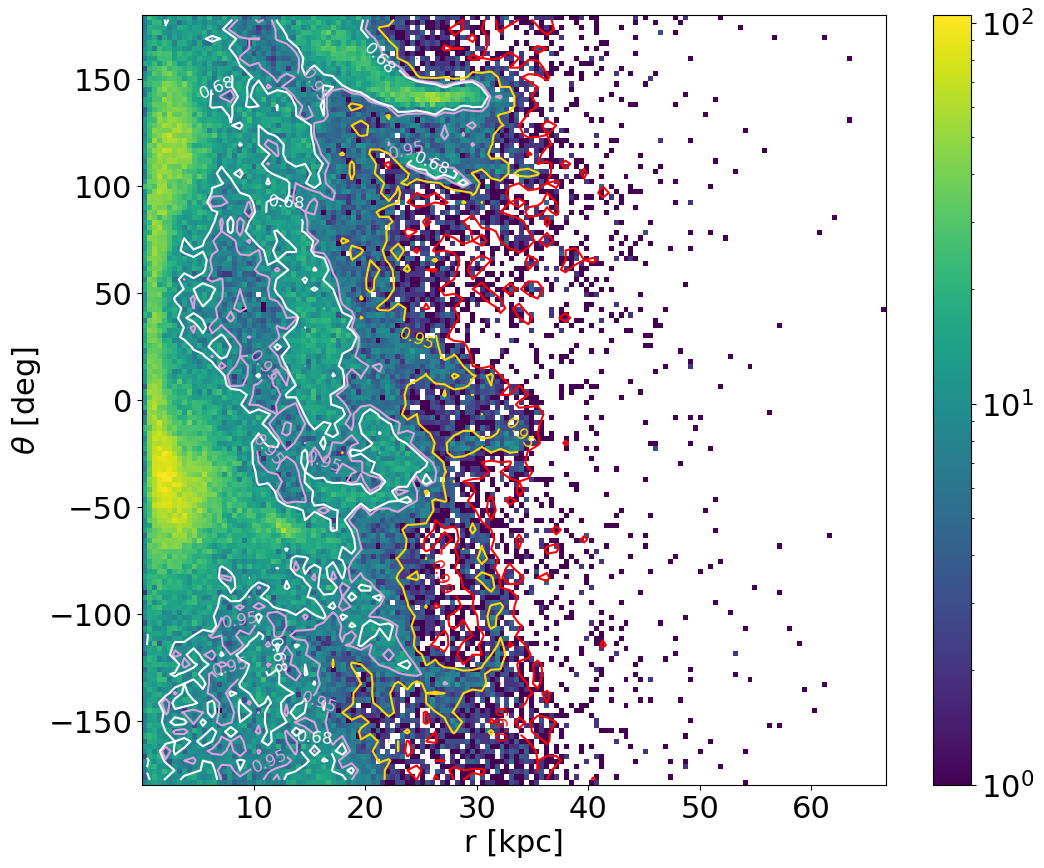

In [207]:
# Make a phase diagram of R vs Theta

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

# Plot 2D Histogram of r vs theta
# ADD HERE
plt.hist2d(cyl_r, cyl_theta, bins=150, norm=LogNorm())
plt.colorbar()

#Add density contour
density_contour(cyl_r, cyl_theta, 80, 80, ax=ax, colors=['red', 'gold', 'plum', 'white'])


# Add axis labels
plt.xlabel('r [kpc]', fontsize=22)
plt.ylabel(r'$\theta$ [deg]', fontsize=22)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Save file
plt.savefig('Lab7_SpiralPhase.png')